# Estimador de Parâmetros

Neste arquivo apresentaremos um estimador de parâmetros do modelo do motor de indução baseado no artigo de Bortoni et al. (2018). https://www.arandanet.com.br/revista/em/edicao/2018/maio

## Levantamento de dados

Primeiro passo é tomar os dados do fabricante por meio do datasheet fornecido pelo fabricante. 

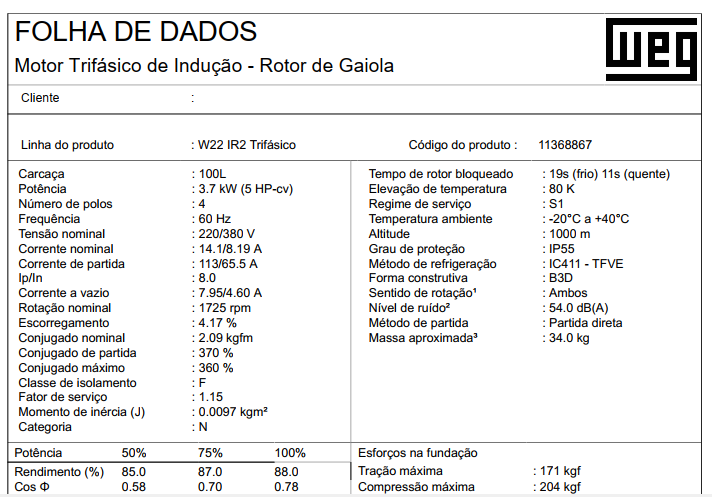

Os dados utilizados nesse código segue abaixo:

In [17]:
Mst_r = 3.7; %relação conjugado de partida/nominal
Mk_r = 3.6; %relação conjugado máx/nominal
Ist_r = 8; %relação corrente de partida/nominal
ns = 1800; %velocidade sincrona
nr = 1725; %velocidade nominal
FP = 0.78; %Fator de potência plena carga
Pn = 3700;
In = 8.19; V1 = 380; %corrente e tensão nominal (380 V)

Para estimação das curvas da resistência do estator e do rotor são necessárias as curvas de potência, eficiência, escorregamento e corrente.

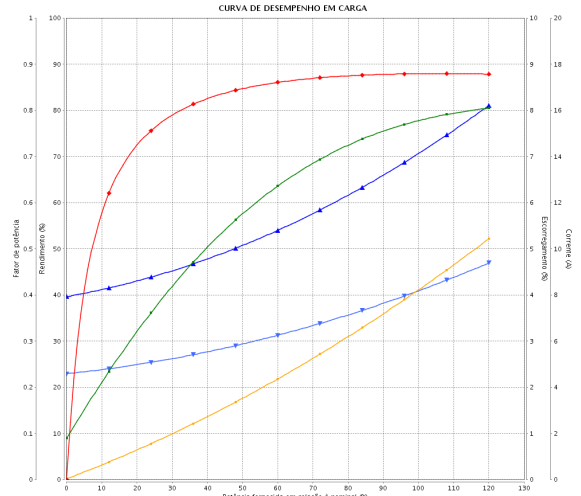

In [18]:
% curvas
P2 = 3700*[0.12 0.246667 0.36 0.486667 .60 0.726667 0.846667 0.96 1.08 1.2]; %Potência
Eff =[62 75 82 85 86 87 87.5 87.7 87.7 87.5]; %Eficiência
s =[0.4 0.7 1.3 1.7 2.2 2.7 3.4 3.9 4.55 5.2]; %Escorregamento
I1 =[  4.6 5.3 5.6 5.9 6.5 6.8 7.3 8 8.8 9.5 ]; %Corrente

Em toda condição de operação, existe um equilíbrio no motor no qual a energia eletromagnética é o resultado da subtração, em relação à energia de entrada, das perdas rotacionais e das perdas no cobre do estator (BORTONI, 2018).

$\frac{P_{2}}{Eff} - \frac{P_{2}}{1-s} = 3r_{1}I_{1}^{2} + P_{rot}$

Desta maneira, é possível estimar a inclinação $r_{1}$ e as perdas na rotação $P_{rot}$ por meio de um ajuste linear, portanto calculamos:

In [19]:
%Resistências
yr1 = P2*100./Eff - P2*100./(100-s); %Estimação da inclinação (R1)
xr1 = 3*I1.^2;

%minimização do erro quadrático (pseudo-inversão)

A = [xr1'  ones(length(xr1),1)];
C = pinv(A)*yr1'; YR1=C(1)*xr1+C(2);
r1 = C(1); Prot = C(2);



De moto similar podemos estimar a resistência do rotor vista do estator a partir do seguinte balanço de potências:

$\frac{P_{2} * s}{1-s} = 3r_{2}I_{2}^{2} + K $



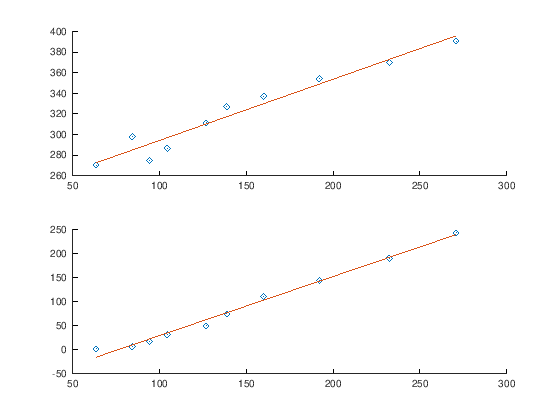

In [20]:
 %Estimação da inclinação (R2)
yr2_= P2.*(s./(100-s));xr2_=xr1;
%minimização do erro quadrático (pseudo-inversão)
A = [xr2_'  ones(length(xr2_),1)];
C2 = pinv(A)*yr2_'; YR2 = C2(1)*xr2_+C2(2);
r2_ = C2(1);

%Plot
figure(2)
subplot(2,1,1) % Em vermelho a reta que estima R1
hold on
plot(xr1,yr1,'d')
plot(xr1,YR1)

subplot(2,1,2)
hold on

plot(xr2_,yr2_,'d') % Em vermelho a reta que estima R2'
plot(xr2_,YR2)

Estimação dos demais parâmetros com base no artigo de Bertoni et al (218).

In [26]:

sr = (ns-nr)/ns;                                   % escorregamento nominal
sk = sr*(Mst_r + sqrt(Mst_r^2-1));                 % escorregamento durante o conjugado máximo
I2 = I1*FP*sqrt(1+(sr/sk)^2);                      % Cálculo da corrente do rotor baseada no fator de potência
r_20 = (1/3)*(ns/nr)*(Mst_r*P2/(Ist_r*I2).^2);     % resistência do rotor durante a partida
gr = log(r_20/r2_)/(sqrt(1-sr));                   % Fator de variação da resistência do rotor 
r_2k = r_20*exp(gr*sqrt(1-sk));                    % resistência do rotor durante o conjugado máximo
xs = sqrt((V1/(Ist_r*In))^2 - (r1+r_20)^2);        % reatância de curto circuito
x1 = (0.6 - 0.3*Mst_r/Mk_r)*xs;                    % reatância de dispersão do estator
x_20 = xs - x1;                                    % reatância do rotor na partida
x_2k = r_2k/sk;                                    % reatância do rotor no conjugado máximo
gx = log(x_20/x_2k)/sqrt(1-sk);                    % fator de variação da reatância
x2_= x_20*exp(gx*sqrt(1-sr));                      % reatância de dispersão do rotor referenciada do estator

In [30]:
%parâmetros de magnetização

E = V1 - In*(r1^2 + x1^2)^0.5;                     % Tensão sobre o ramo de magnetização
rm = (E^2)/Prot;                                   % Resistência de magnetização 
In2 = In*FP*sqrt(1+(sr/sk)^2);                     % Corrente do rotor em plena carga
xm = E/sqrt(In^2-In2^2-(E/rm)^2);                  % Reatância de magnetização

% Display
sprintf('Resistência Estator (r1): %.4f ; Reatância Estator (x1): %.4f;', r1, x1) 
sprintf('Resistência Rotor (r2"): %.4f ; Reatância do Rotor (x2"): %.4f;', r2_,x2_)
sprintf('Resistência Magnetização (rm): %.4f ; Reatância de Magnetização: %.4f;', rm, xm)

ans = Resistência Estator (r1): 0.5944 ; Reatância Estator (x1): 1.5576;
ans = Resistência Rotor (r2"): 1.2296 ; Reatância do Rotor (x2"): 1.7937;
ans = Resistência Magnetização (rm): 571.4782 ; Reatância de Magnetização: 73.1489;
